# 线性回归

In [1]:
import numpy as np
import math 
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
import matplotlib.pylab as plt

## 1 数据准备

In [2]:
def shuffle_data(X, y, seed=None):
    "将数据集中的X和y打乱"
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [3]:
def train_test_split(X, y, test_size=0.5, shuffle=True,seed=None):
    "将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌"
    if shuffle:
        X, y = shuffle_data(X, y, seed=seed)
    split_i = len(y) - int(len(y) // (1/test_size))
    X_train, X_test = X[ :split_i], X[split_i: ]
    y_train, y_test = y[ :split_i], y[split_i: ]
    return X_train, y_train, X_test, y_test

In [4]:
# 关键参数有n_samples（生成样本数），n_features（样本特征数），noise（样本随机噪音）和coef（是否返回回归系数
# X为样本特征，y为样本输出， coef为回归系数，共1000个样本，每个样本1个特征
# 使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题(线图会展示出乱七八糟的)，所以对于X进行排序
X, y = make_regression(n_samples=200, n_features=1, noise=20)

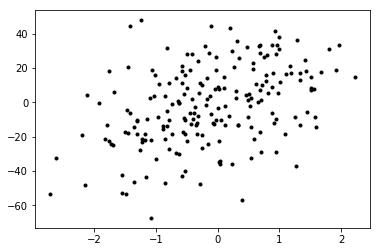

In [5]:
plt.plot(X, y, "k.")

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2) 

In [7]:
s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

In [8]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

## 2 线性回归

In [9]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.regularization = lambda x:0
        self.regularization.grad = lambda x:0
        
    # 为什么要这样初始化呢？
    def initialize_weights(self,n_features):
        "初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"
        limit = 1/math.sqrt(n_features)
        self.w = np.random.uniform(-limit,limit,(n_features,))
    
    def fit(self,X,y):
        # 插入偏置列1到X中
        X = np.insert(X,0,1,axis=1)  # 给每一行的第0列增加一个1
        self.training_errors = []    # 保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])   # 初始化参数w
        
        # 进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)    # 进行预测
            # 计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred

In [10]:
model=Regression(n_iterations=1000,learning_rate=0.01)

In [11]:
model.fit(X_train,y_train)

Text(0.5, 0, 'Steps')

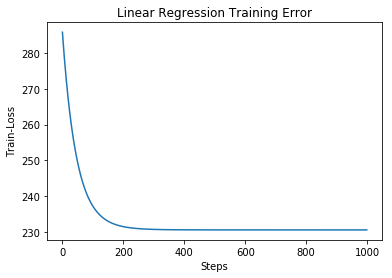

In [12]:
training =plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

In [13]:
model.w

array([-0.62030347,  9.59103356])

## 3 评价模型

In [14]:
y_pred = model.predict(X_test)

In [15]:
mse = mean_squared_error(y_pred,y_test)

In [16]:
mse

372.4060857491928

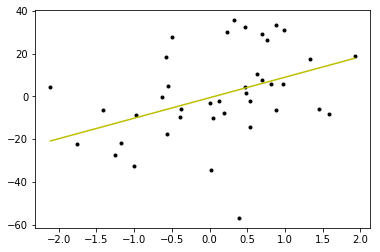

In [17]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

## 4 最小二乘法线性回归

In [18]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [19]:
lsm_function(X_train,y_train)

array([-0.61922854,  9.59207039])

In [20]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    learning_rate
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)

In [21]:
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [22]:
model.fit(X_train,y_train)

In [23]:
model.w

array([-0.61922854,  9.59207039])

In [24]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 372.4067284532685


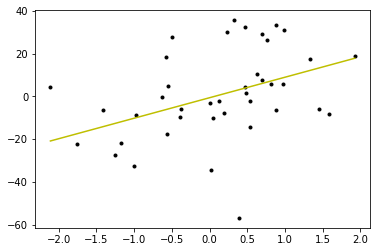

In [25]:
test_and_draw(model)

## 5 正则化回归
### 5.1 L1 正则化

In [26]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [27]:
l1=l1_regularization(alpha=0.01)

In [28]:
l1([-3,4])

0.07

In [29]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### 5.2 L2正则化

In [30]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

### 5.3 Lasso线性回归

In [31]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [32]:
model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [33]:
model.fit(X_train,y_train)

In [34]:
model.w

array([-0.61922854,  9.59207039])

方差: 372.4067284532685


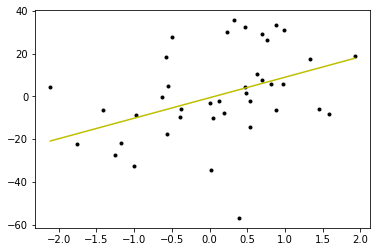

In [35]:
test_and_draw(model)

In [36]:
f = lambda x:0

In [37]:
f(2)

0

## 疑问
1 初始参数的选择？
2 梯度下降的实现过程：不太明白梯度怎么计算的。

### 5.4 Ridge线性回归

In [38]:
class RidgeLinearRegression(Regression):
    def __init__(self, alpha,n_iterations=1000,learning_rate=0.01):
        self.ragularization = l2_regularization(alpha=alpha)
        super(RidgeLinearRegression, self).__init__(n_iterations, learning_rate)
        
    def fit(self, X, y):
        super(RidgeLinearRegression, self).fit(X, y)
    
    def predict(self, X):
        return super(RidgeLinearRegression, self).predict(X)

In [39]:
ridge_model = RidgeLinearRegression(alpha=120, n_iterations=1000, learning_rate=0.01)

In [40]:
ridge_model.fit(X_train, y_train)

In [41]:
ridge_model.w

array([-0.62025952,  9.59107271])

方差: 372.4061055801068


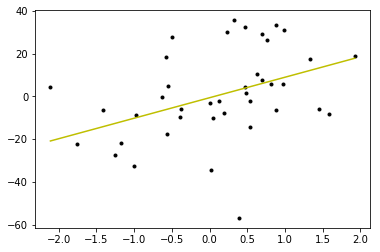

In [42]:
test_and_draw(ridge_model)

### 5.5 L1/L2调和的正则化
- 在调和的正则化中：
    - l1_ratio:在调和时，L1正则化的值所占的百分比[0,1]
    - l2_ratio=1 - l1_ratio（事实上算法中也找不到l2_ratio）
    - alpha: 全局整体的正则化权重
    - $ Loss = mse + \alpha * (l1\_ratio * L1Loss) + (1-l1\_ratio) * L2Loss) $

In [43]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        
    def __call__(self, w):
        l1_loss = self.l1_ratio * np.linalg.norm(w, ord=1)
        l2_loss = (1- self.l1_ratio)*0.5*np.linalg.norm(w)**2
        return self.alpha*(l1_loss + l2_loss)
    
    def grad(self, w):
        l1_grad = self.l1_ratio*np.sign(w)
        l2_grad = (1-self.l1_ratio)*w
        return self.alpha*(l1_grad + l2_grad)

In [44]:
l1_l2 = l1_l2_regularization(alpha=0.1)

In [45]:
l1_l2(np.array([3, 4]))

0.9750000000000001

### 5.6 ElasticNet线性回归

In [46]:
class ElasticNetLinearRegression(Regression):
    def __init__(self, alpha, l1_ratio, n_iterations=2000, learning_rate=0.01):
        self.regularazition = l1_l2_regularization(alpha, l1_ratio=0.5)
        super(ElasticNetLinearRegression,self).__init__(n_iterations, learning_rate)
    
    def fit(self, X, y):
        super(ElasticNetLinearRegression,self).fit(X, y)
    
    def predict(self, X):
        return super(ElasticNetLinearRegression,self).predict(X)

In [47]:
elastic_model = ElasticNetLinearRegression(alpha=1.2, l1_ratio=0.5)

In [48]:
elastic_model.fit(X_train, y_train)

方差: 372.40672834672534


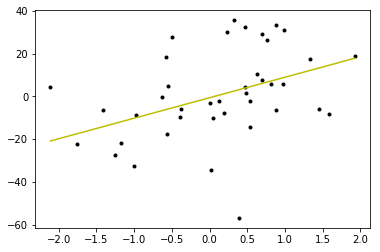

In [49]:
test_and_draw(elastic_model)

## 6 多项式回归
- 一阶多项式：$x_1,x_2,x_3$
- 二阶多项式：$x_1^2, x_2^2, x_3^2,x_1x_2,x_1x_3,x_2x_3$
- 三阶多项式：$x_1^3, x_2^3...$

### 6.1 构造多项式特征

In [50]:
from itertools import combinations_with_replacement

def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)
    
    # 对于每一行的feature构造排列组合，根据排列组合进行特征乘积，形成新的X`
    def index_combinations():
        combs = [combinations_with_replacement(range(n_features),i) for i in range(0, degree+1)]
        new_combs = [item for sub in combs for item in sub]
        return new_combs
    # print("Feature 列的排列组合：->", [x for x in index_combinations()])
    comb = index_combinations()
    feature_length = len(comb)
    output = np.empty((n_samples, feature_length))
    # print(output.shape)
    for i, index_combs in enumerate(comb):
        # print(i, index_combs)
        # 元素乘积
        output[:, i]= np.prod(X[:, index_combs], axis=1)
    return output

In [51]:
polynomial_features(np.array([[1,2], [4,5]]), degree=2)

array([[ 1.,  1.,  2.,  1.,  2.,  4.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [52]:
a = np.array([[1,2], [4,5]])
a

array([[1, 2],
       [4, 5]])

In [53]:
np.prod(a[:, (0,1)], axis=1)

array([ 2, 20])

In [54]:
class PolyRegression(Regression):
    """
    多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归。
    ----------------
    degree：最大的阶数
    n_iterations:int
    learning_rate:float
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = lambda x:0
        self.regularization.grad = lambda x:0
        super(PolyRegression, self).__init__(n_iterations, learning_rate)
    
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolyRegression, self).fit(X, y)
    
    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolyRegression, self).predict(X)
       

In [55]:
poly_model = PolyRegression(degree=4)

In [56]:
poly_model.fit(X_train, y_train)

方差: 379.63407109735056


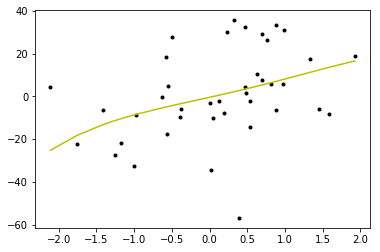

In [57]:
test_and_draw(poly_model)

## 7 数据的Normalize变换（归一化操作）
- 行归一化

In [58]:
def normalize(X, axis=-1, order=2):
    """将数据集的每一行进行列的归一化，--每一行的向量的L2范数归一"""
    L2 = np.linalg.norm(X, order, axis)
    L2[L2==0] = 1 # 为了过滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2, axis)

In [59]:
a = np.linalg.norm([[1,2], [3,4]], ord=2, axis=-1)
a

array([2.23606798, 5.        ])

In [60]:
np.expand_dims(a,axis=-1)

array([[2.23606798],
       [5.        ]])

In [61]:
normalize([[1,2], [3,4]], axis=-1, order=2)

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

## 8 带多项式回归
### 8.1 多项式Lasso回归

In [62]:
class LassoRegression(Regression):
    """
    带有L1范数的Lasso多项式回归
    ---------------------------
    degree:多项式的最高阶
    alpha:L1的系数
    n_iteration:int
    learning_rate:float
    normailzed:bool
    """
    def __init__(self, degree, alpha, n_iterations=2000, learning_rate=0.01, normalized=True):
        self.degree = degree
        self.normalized = normalized
        self.regularization = l1_regularization(alpha=alpha)
        super(LassoRegression, self).__init__(n_iterations, learning_rate)
        
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X = normalize(X)
        super(LassoRegression, self).fit(X,y)
        
    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X = normalize(X)
        return super(LassoRegression, self).predict(X)

In [63]:
l_model = LassoRegression(degree=5,alpha=1000,n_iterations=2000,learning_rate=0.1)

In [64]:
l_model.fit(X_train, y_train)

In [65]:
l_model.w

array([-6.57001691,  6.34368823,  9.53548132,  2.96579119, -6.38791892,
        5.99176103, 20.27400916])

方差: 365.87629688328997


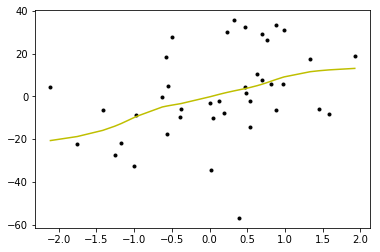

In [66]:
test_and_draw(l_model)

### 8.2 多项式Ridge回归

In [67]:
class RidgeRegression(Regression):
    """
    带L2范数的多项式Ridge回归
    degree:最大阶数
    alpha:正则化系数
    n_iterations:步数
    learning_rate:步长
    normalized:bool 是否归一化
    """
    def __init__(self, degree, alpha, n_iterations=2000, learning_rate=0.01, normalized=True):
        self.degree = degree
        self.normalized = normalized
        self.regularization = l2_regularization(alpha=alpha)
        super(RidgeRegression, self).__init__(n_iterations, learning_rate)
        
    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X = normalize(X)
        super(RidgeRegression, self).fit(X,y)
        
    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X = normalize(X)
        return super(RidgeRegression, self).predict(X)

In [68]:
r_model = RidgeRegression(degree=3, alpha=100, n_iterations=2000, learning_rate=1, normalized=True)

In [69]:
r_model.fit(X_train, y_train)

In [70]:
r_model.w

array([-9.28448034,  8.35845988,  2.4305525 ,  9.57981532, 17.97770943])

方差: 359.9947494430938


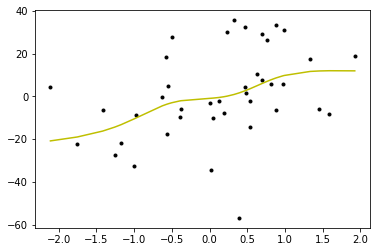

In [71]:
test_and_draw(r_model)

### 8.3 多项式ElasticNet回归

In [72]:
class ElasticNetRegression(Regression):
    """
    带有L1L2调和的多项式回归
    -----------------
    degree
    alpha
    l1_ratio
    n_iterations
    learning_rate
    
    normalized
    """
    def __init__(self,degree,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree=degree
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        self.normalized=normalized
        super(ElasticNetRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(ElasticNetRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return super(ElasticNetRegression,self).predict(X)

In [73]:
e_model = ElasticNetRegression(degree=4,alpha=2000,l1_ratio=0.8,n_iterations=1000,learning_rate=0.01)

In [74]:
e_model.fit(X_train, y_train)

In [75]:
e_model.w

array([-1.39600649,  1.91739235,  7.9700457 ,  0.5770513 , 13.97814608,
       -3.58686224])

方差: 357.11821253034304


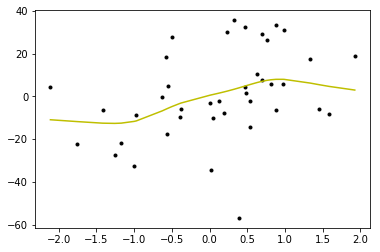

In [76]:
test_and_draw(e_model)

## 9 读入真实的数据

In [77]:
import pandas as pd

In [78]:
data = pd.read_csv("../../kaggle/forecast_losa_house_prices/data/train_1.csv")

In [79]:
y=np.asarray(data['SalePrice'])

In [80]:
train1=data.drop(['Id','SalePrice'],axis=1)

In [81]:
X=np.asarray(pd.get_dummies(train1).reset_index(drop=True))

In [95]:
X_train,y_train, X_test,y_test=train_test_split(X,y,test_size=0.2)

In [96]:
X_train.shape

(1168, 305)

In [97]:
X_test.shape

(292, 305)

In [98]:
y_train.shape

(1168,)

In [99]:
y_test.shape

(292,)

### 9.1 多项式Lasso回归

In [100]:
l_model = LassoRegression(degree=2,alpha=1000,n_iterations=2000,learning_rate=0.1)

In [101]:
l_model.fit(X_train, y_train)

In [102]:
# 计算方差的log值
def print_logrmse(model):
    pred=model.predict(X_test)
    logrmse=np.sqrt(mean_squared_error(np.log(abs(y_test)),np.log(abs(pred))))
    return "logrmse:", logrmse

In [103]:
print_logrmse(l_model)

('logrmse:', 0.28079735597467403)

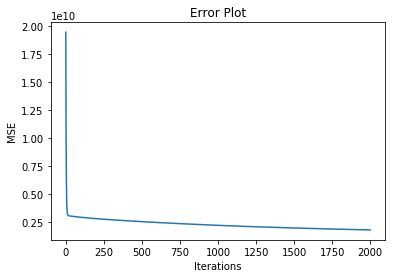

In [104]:
n=len(l_model.training_errors)
training=plt.plot(range(n),l_model.training_errors,label="Training Error")
#plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.show()

### 9.2 多项式ElasticNet回归 

In [105]:
model=ElasticNetRegression(degree=2,alpha=1000,l1_ratio=0.5,n_iterations=20000,learning_rate=0.001)

In [106]:
model.fit(X_train, y_train)

In [107]:
print_logrmse(model)

('logrmse:', 0.37242180029341715)

In [108]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [109]:
def benchmark(model,testset,label):
    pred=model.predict(testset)
    print(pred)
    if pred[pred<0].shape[0]>0:
        print("Neg Value")
        return -1
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(abs(pred))))
    print("RMSE:",rmse)
    print("LRMSE:",lrmse)
    return lrmse

In [110]:
def train_test():
    model=make_pipeline(RobustScaler(),ElasticNetRegression(degree=1,alpha=1000,l1_ratio=0.5,n_iterations=80000,learning_rate=0.001))
    model.fit(X_train,y_train)
    lrmse=benchmark(model,X_test,y_test)

In [111]:
train_test()

[106754.48655819 255086.5241515  145757.60918634 106069.80326649
 122995.41294463 168977.01096839 103526.25990389 166991.03298527
 167537.18339673 196441.87153271 280692.30380664 162032.25042135
 268334.03901221 305576.36165366 208656.16818301 267926.19845725
 205725.58865219 148011.39303307 146046.91496532 148925.00344539
 100637.04083691 147197.43880261 214167.87902052 207651.22874989
 149517.64748852 168419.00331264 153388.45217941 167509.83846731
 166798.21268892 166829.44894026  90443.34676442 144140.24220001
 163643.2836085  196320.03919169 260325.40335169  60471.01106438
 247646.76037599 162875.08881834 201277.21746466 168186.65623429
 136514.51105475 207227.88287557 140058.3840455  322358.87331648
 166501.70178633 180693.01324454 239913.87502848 151932.79155685
 183956.99834674  86415.98084795 165569.40147818 197323.98150807
 306634.841977   272849.10055013 297532.25290743 204959.50821783
 189012.98644727 299069.68783823 147252.71326363 185752.17419272
 244400.51950165 115630.0

## 10 xgboost训练

In [112]:
import xgboost as xgb

In [113]:
xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3400,subsample=0.7,nthread=6,seed=123)

In [114]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3400,
       n_jobs=1, nthread=6, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.7)

## 11 stacking集成算法